In [1]:
import os 
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [2]:

from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle
import matplotlib

In [3]:
mode = "frequencies"

In [4]:
def load_liks(itraj, mode="damping", dtt=1e-6, total_time_in=6.):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l1  = logliks[:,0] - logliks[:,1]
    
    pars = give_def_params_discrimination(flip=1, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l0  = logliks[:,1] - logliks[:,0]
      
    return l0, l1

In [12]:
dt = 1e-4
T = total_time = 60.
ppp=5*1e3

pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

total_time, dt = get_total_time_dt(params, dt=dt, total_time=T, ppp=ppp)

times = np.arange(0, total_time+ dt, dt)


indis = np.logspace(1,np.log10(len(times)-1), 1000)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]





Ntraj = 3000
boundsB= np.arange(-4,4.1,.1)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))#{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))##{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}



n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode, dtt=dt, total_time_in=total_time)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b


                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0

                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2999/2999 [08:14<00:00,  6.07it/s]


In [13]:
bpos = boundsB[boundsB >=0]
bneg = boundsB[boundsB <0]

stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())

for k,val in enumerate(values1):
    if len(val)>2:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


In [14]:
                
cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(boundsB[int(len(boundsB)/2):]):
    counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms1]
    anals1.append(gp1)
    
    gp0 = [prob(t, b, kappa1, kappa0, eta1 , eta0, n1, n0, gamma1, gamma0)[0] for t in timms0]
    anals0.append(gp0)
    

/tmp/ipykernel_1713873/2599556454.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
/tmp/ipykernel_1713873/2599556454.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
/home/giq/Desktop/continuous/numerics/utilities/misc.py:155: RuntimeWarning: divide by zero encoun

In [15]:
path = get_def_path()+"results_stopping_time/paper_{}/".format(mode)
path_data = get_def_path()+"results_stopping_time/paper{}_{}/".format(Ntraj,mode)
os.makedirs(path,exist_ok=True)
os.makedirs(path_data,exist_ok=True)



with open(path_data+"stop.pickle","wb") as f:
    pickle.dump(stop, f, protocol=pickle.HIGHEST_PROTOCOL)
    

with open(path_data+"deter.pickle","wb") as f:
    pickle.dump(deter, f, protocol=pickle.HIGHEST_PROTOCOL)
    
np.save(path_data+"timbin", timbin1)
np.save(path_data+"cons", cons1)
np.save(path_data+"timbin", timbin0)
np.save(path_data+"cons", cons0)
np.save(path_data+"gp0", gp0)
np.save(path_data+"gp1", gp1)
np.save(path_data+"deth1h0", deter_data_h1_h0)
np.save(path_data+"deth0h1", deter_data_h0_h1)
np.save(path_data+"anals0",anals0)
np.save(path_data+"anals1",anals1)

np.save(path_data+"l0",l0)
np.save(path_data+"l1",l1)

NOW PLOT!

In [6]:
mode = "frequencies"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

dtt = 1e-6
T = 50.
ppp=1e4
total_time, dt = get_total_time_dt(params, dt=dtt, total_time=T, ppp=ppp)
times = np.arange(0, total_time+ dt, dt)


In [33]:


indis = np.logspace(0,np.log10(len(times)-1), 1000)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]


Ntraj = 1000
boundsB= np.arange(-4,4.1,.1)


path_data = get_def_path()+"results_stopping_time/paper{}_{}/".format(Ntraj,mode)


timbin1 = np.load(path_data+"timbin.npy")
cons1 = np.load(path_data+"cons.npy")#, cons1)
timbin0 = np.load(path_data+"timbin.npy")#, timbin0)
cons0 = np.load(path_data+"cons.npy")#, cons0)
gp0 = np.load(path_data+"gp0.npy")#, gp0)
gp1 = np.load(path_data+"gp1.npy")#, gp1)
deter_data_h1_h0 = np.load(path_data+"deth1h0.npy")#, deter_data_h1_h0)
deteR_data_h0_h1 = np.load(path_data+"deth0h1.npy")#, deter_data_h0_h1)
anals0 = np.load(path_data+"anals0.npy")
anals1 = np.load(path_data+"anals1.npy")#,anals1)
l0 = np.load(path_data+"l0.npy")
l1 = np.load(path_data+"l1.npy")

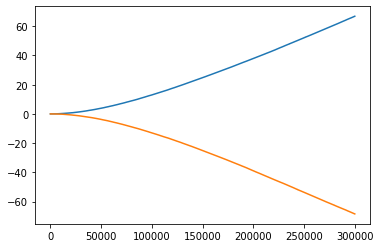

In [16]:
plt.plot(l1)
plt.plot(l0)

In [18]:
with open(path_data+"stop.pickle","rb") as f:
    stop = pickle.load( f)#, protocol=pickle.HIGHEST_PROTOCOL)

with open(path_data+"deter.pickle","rb") as f:
    deter = pickle.load(f)#, protocol=pickle.HIGHEST_PROTOCOL)
    
alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)

In [36]:
tot_err.shape

(81, 1000)

In [19]:

times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

std_times = np.sqrt(std_times1**2   + std_times0**2)#0.5*(np.array(avg_times0) + np.array(avg_times1) )
stoch = avg_times
stoch_std = std_times


avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

In [20]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
b_to_ep = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

In [21]:
bb = np.linspace(0,1000,1000)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(bb):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

In [22]:
bb = boundsB #np.linspace(0,1000,100)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(boundsB):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

In [38]:
def prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1, mu=None):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

#    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    S= np.sqrt(2*mu)

    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

0.03677962131031953

In [71]:
times_alpha_to_errB/stoch

array([23.33333333, 15.259053  ,  8.61117732,  6.51423263,  5.41388558,
        4.73832601,  4.29298588,  3.96888992,  3.73106412,  3.58444048,
        3.46427166,  3.32330366,  3.26086072,  3.21912587,  3.1340952 ,
        3.12453615,  3.10596333,  3.03924474,  3.04702052,  3.07350266,
        3.03269476,  3.06649519,  3.04299221,  3.05756838,  3.05569843,
        3.05390386,  3.08931772,  3.12989028,  3.14589525,  3.19573395,
        3.21253139,  3.27529428,  3.27121458,  3.26268476,  3.33399462,
        3.335564  ,  3.34151332,  3.3868099 ,  3.38525457,  3.43428654,
        3.4904131 ])

In [58]:
muu = l1[-1]/times[-1]

In [72]:
timm =  np.linspace(0,.03,100)
popo = [prob(tt, boundsB[indb], kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1, mu=muu/3.5) for tt in timm]

/tmp/ipykernel_1713873/3242409513.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div
/tmp/ipykernel_1713873/3242409513.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div


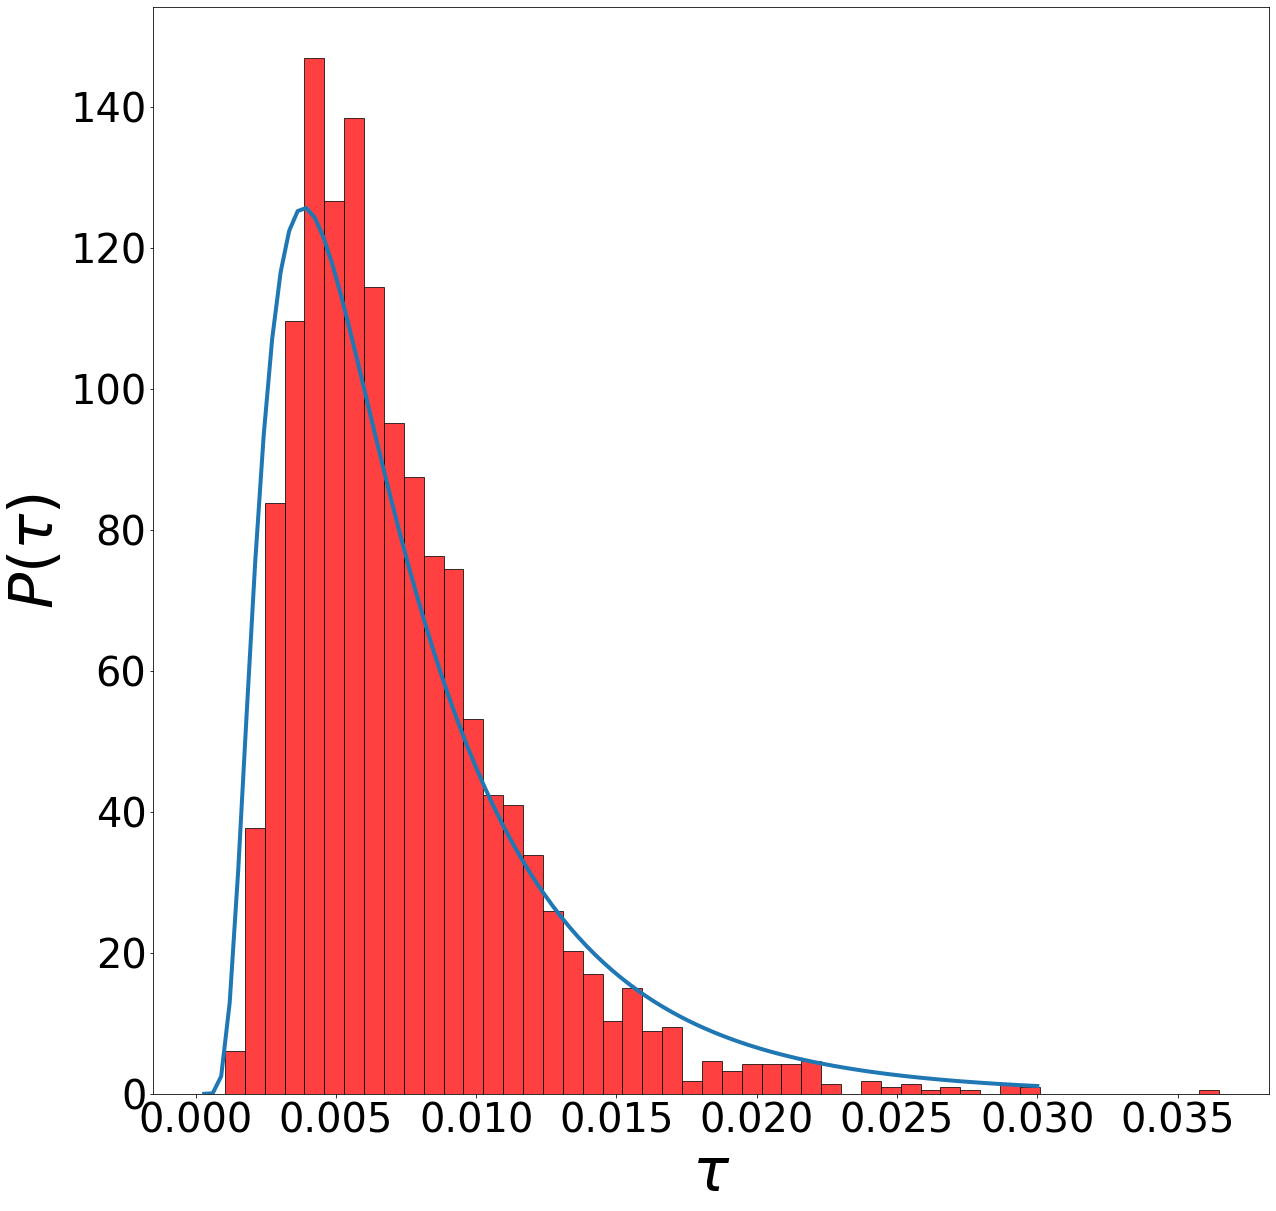

In [73]:
LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = -1
ax.plot(timm,popo, linewidth=4)
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [24]:
with open(path_data+"stop.pickle","rb") as f:
    stop = pickle.load( f)#, protocol=pickle.HIGHEST_PROTOCOL)

with open(path_data+"deter.pickle","rb") as f:
    deter = pickle.load(f)#, protocol=pickle.HIGHEST_PROTOCOL)
    
alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)




bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)
times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

stoch = avg_times

avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

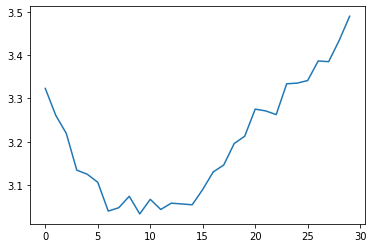

In [29]:
plt.plot((times_alpha_to_errB/stoch)[-30:])

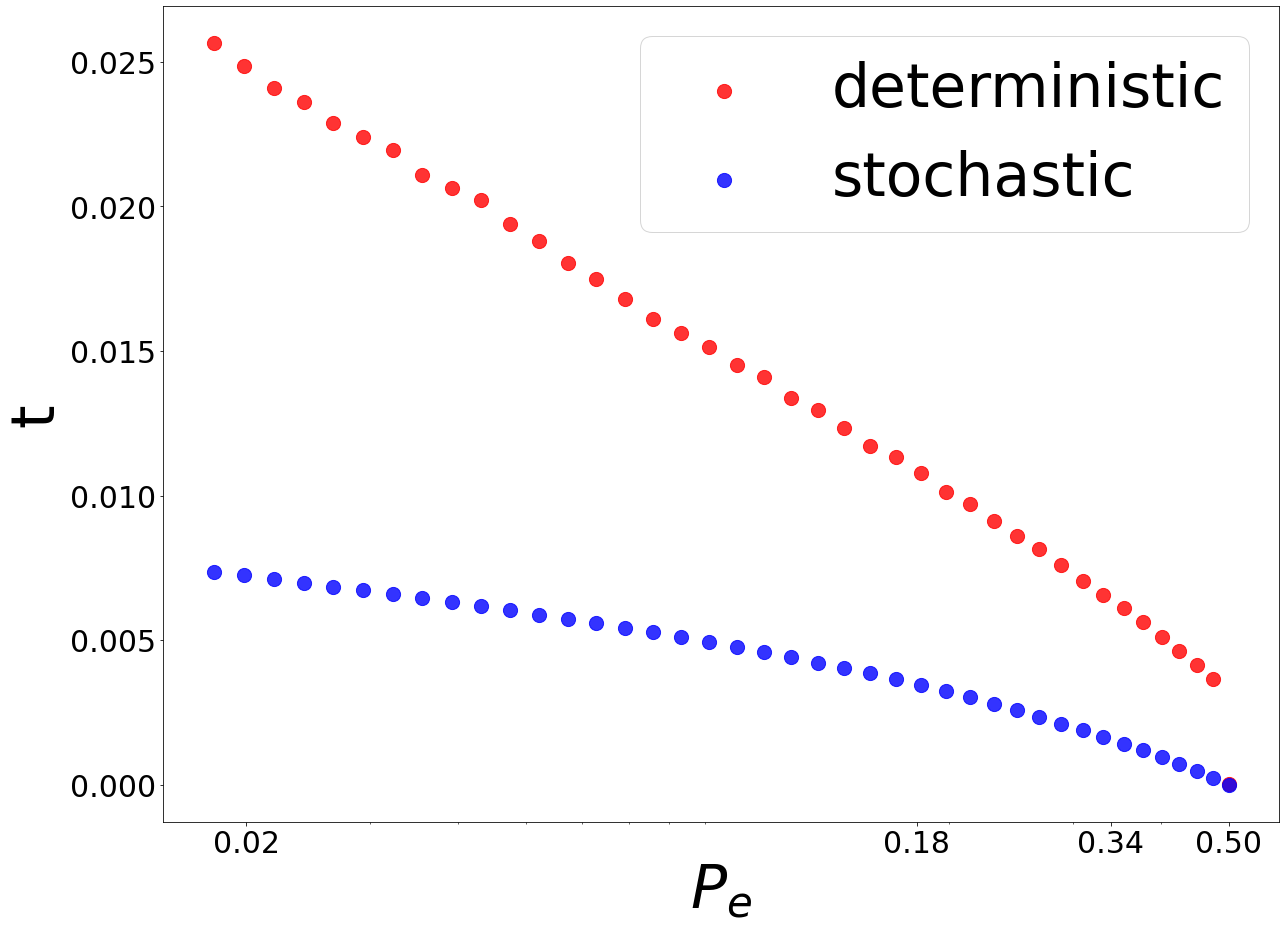

In [25]:

fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
lw=10
TS=30
ax.scatter(errs, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")

#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
ax.set_xscale("log")
ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"freq_adaptive_vs_det.pdf")




In [76]:
l1s, l0s = [], []
for itraj in tqdm(range(1,10**3)):
    try:
        
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode, dtt=dt, total_time_in=total_time)
        l1s.append([log_lik_ratio[k] for k in indis])
        l0s.append([log_lik_ratio_swap[k] for k in indis])
    except Exception:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:11<00:00, 89.66it/s]


In [82]:
def gauss(x,mu, sigma):
    return np.exp(-((x-mu)**2)/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

In [83]:
muLF = l1[-1]/times[-1]

In [86]:
l1s = np.stack(l1s)

In [119]:
def fun(l,x):
    return np.exp(-((l-x)**2)/(4*x**2))/(2*np.pi*np.sqrt(x))

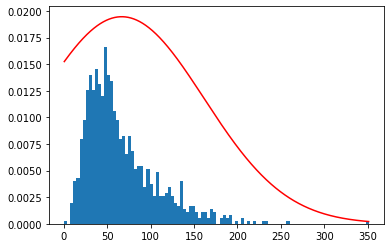

In [120]:
indi = -1
timi = timind[indi]
counts, bins, ploo = plt.hist(l1s[:,indi], bins=100, density=True)
xx = np.linspace(min(bins),max(bins),1000)
gg = [gauss(x,muLF*timi, np.sqrt(2*muLF*timi)) for x in xx]
ff = [fun(x,muLF*timi) for x in xx]
plt.plot(xx,ff, color="red")

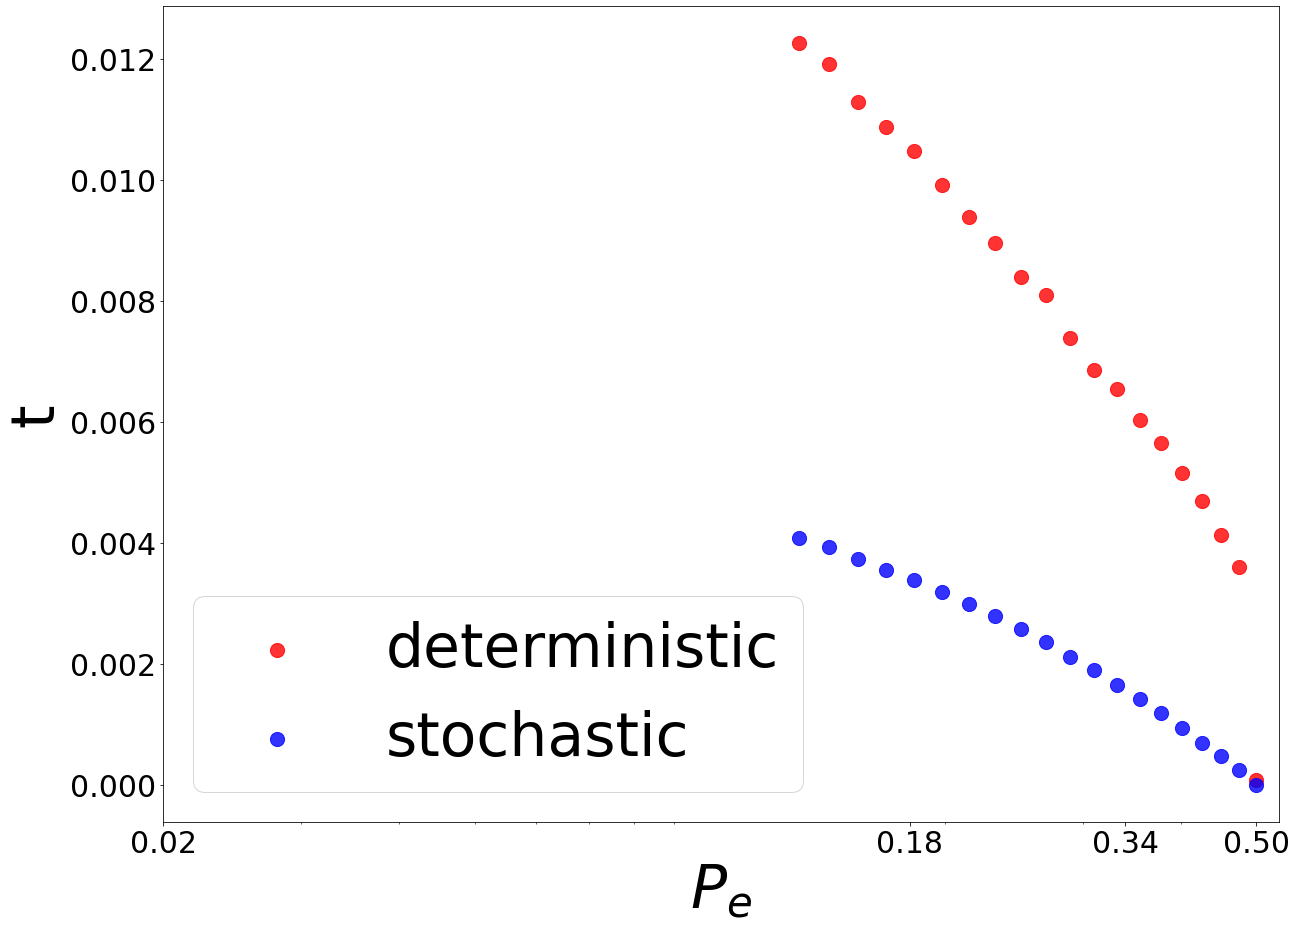

In [60]:

fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
lw=10
TS=30
A = 0
B= 20
ax.scatter(errs[A:B], times_alpha_to_errB[A:B],color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs[A:B], stoch[A:B] ,color="blue",s=200,  alpha=0.8,label="stochastic")

#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
ax.set_xscale("log")
ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"freq_adaptive_vs_det.pdf")




In [ ]:
ll1={}
ll0={}
for k in range(1,5):
    ll1[k], ll0[k] = load_liks(itraj=k, mode="frequencies", dtt=dt, total_time_in=total_time)
    

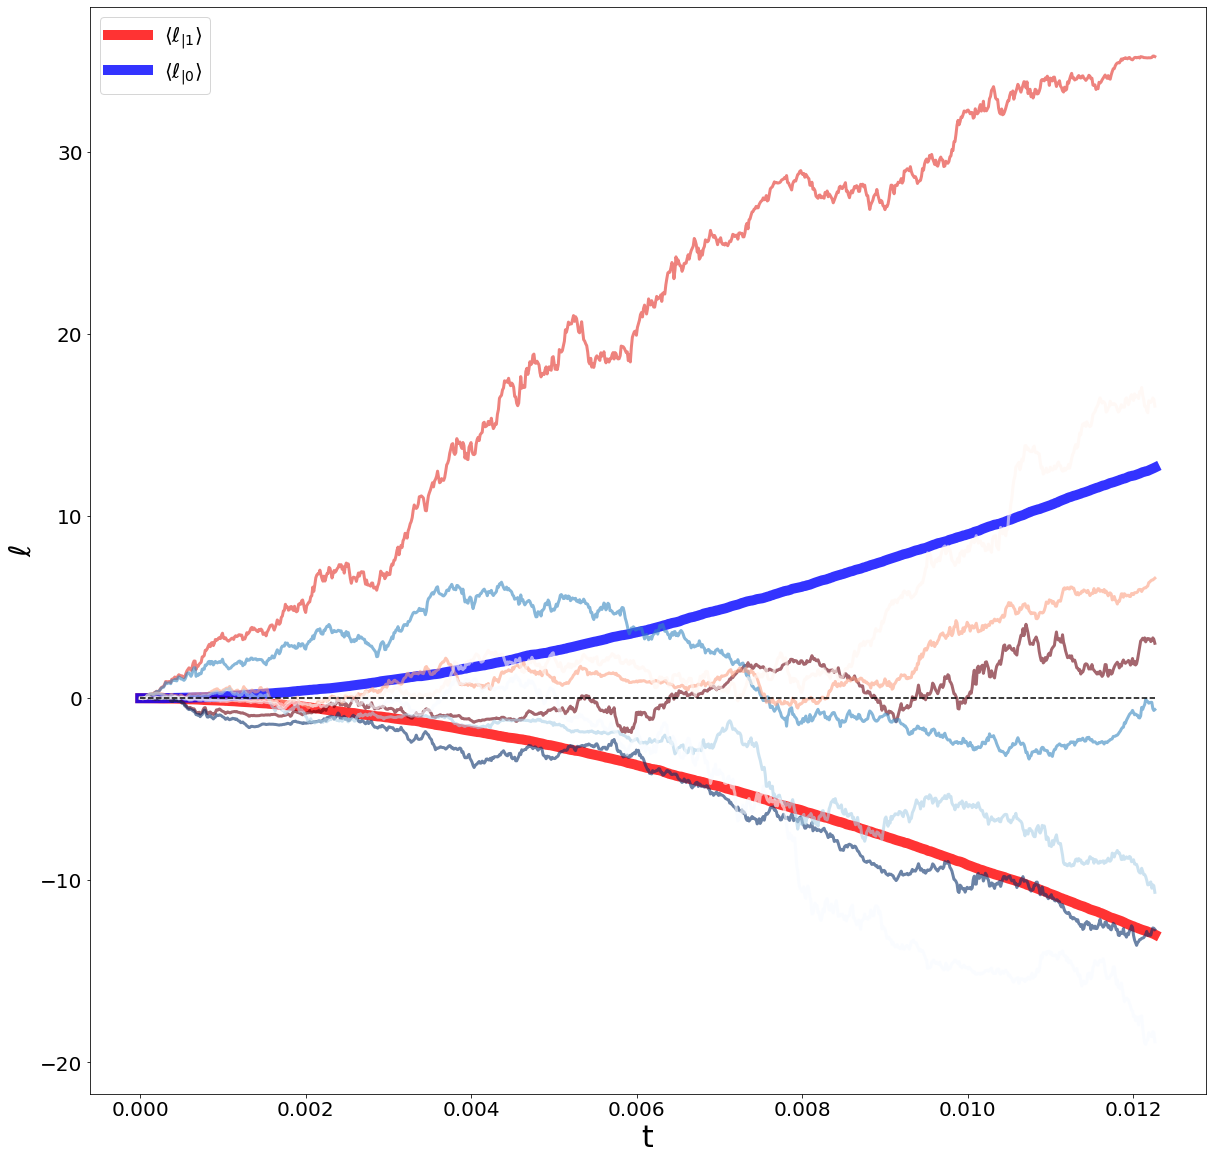

In [50]:
colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")
Ntraj = 4
Ltraj=3
LS=30
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]

jump = 100
plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.plot(times[::jump],l0[:-1][::jump], color="red", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|1} \rangle$')
ax.plot(times[::jump],l1[:-1][::jump], color="blue", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|0} \rangle$')
for ind,k in enumerate(range(1,5)):
    ax.plot(times[::jump],ll1[k][:-1][::jump], color=c1[ind], linewidth=Ltraj, alpha=0.6)
    ax.plot(times[::jump],ll0[k][:-1][::jump], color=c0[ind], linewidth=Ltraj, alpha=0.6)   
ax.plot(times[::jump], np.zeros(len(times))[::jump], '--', color="black")
ax.set_xlabel("t", size=LS)
ax.set_ylabel(r'$\ell$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(prop={"size":20})


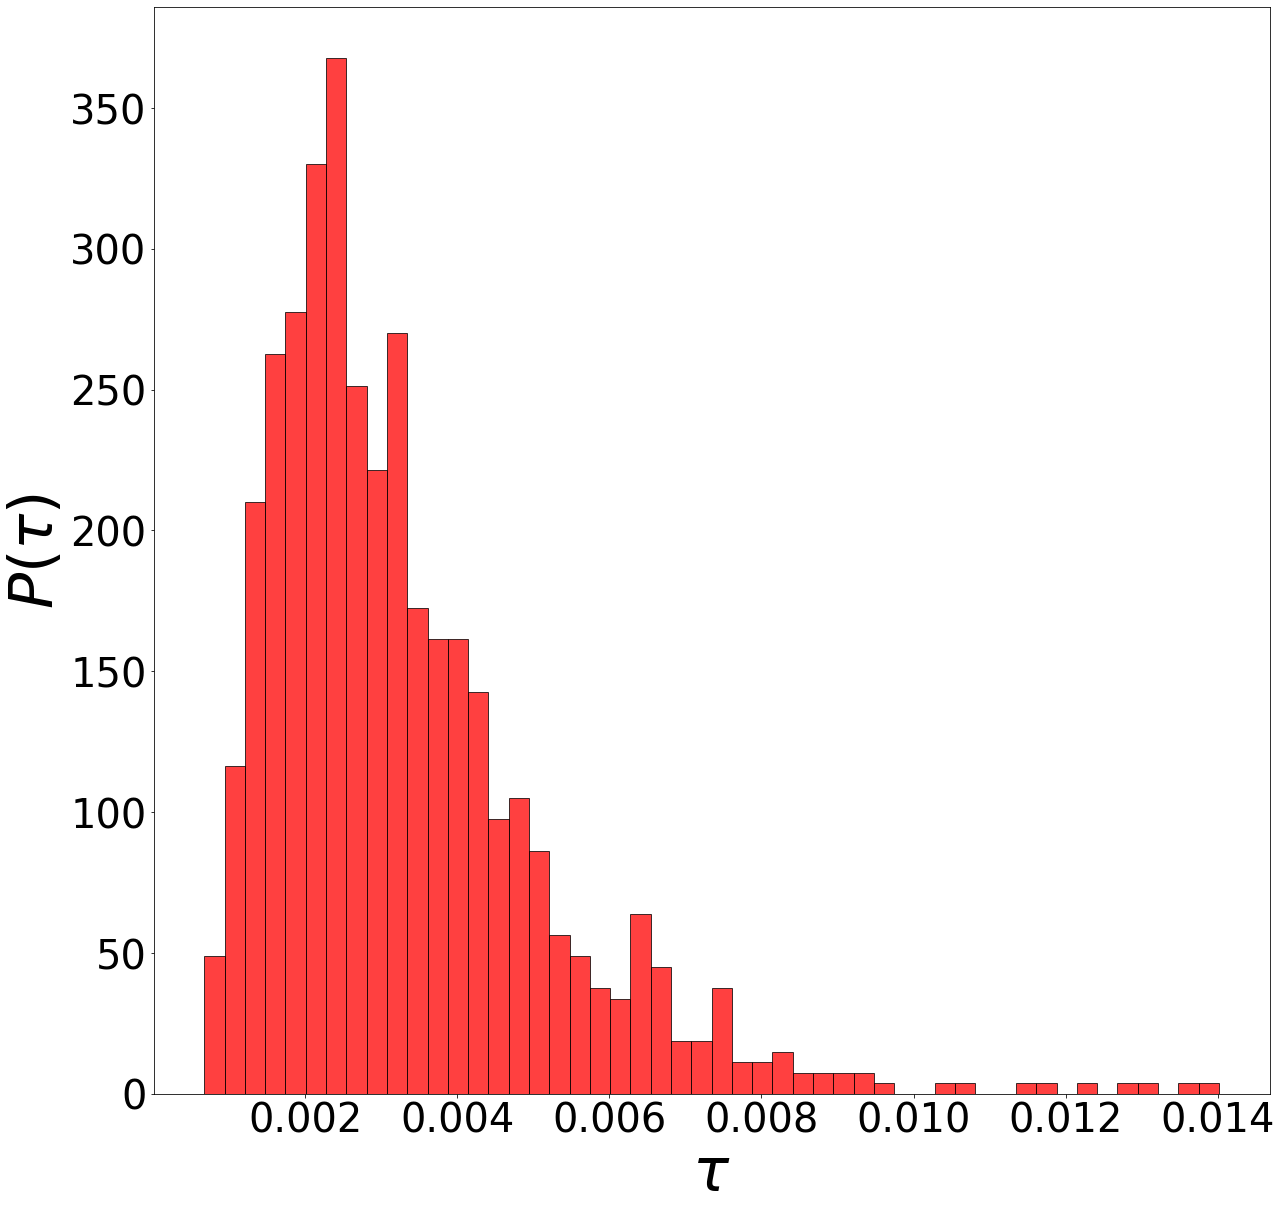

In [146]:
LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = -5
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [125]:
len(stop["_1"])

999

In [147]:
nn=0
for k in list(stop["_1"].values()):
    if k != []:
        nn+=1

In [148]:
nn

999